# Regression on Workers' Compensation Dataset
This notebook demonstrates model diagnostics on the workers' compensation dataset https://www.openml.org/d/42876.
For details, see https://arxiv.org/abs/2202.12780.

The modelling goal is to predict the expectation $E(Y|X)$ of $Y=\text{UltimateIncurredClaimCost}$ conditional on the features $X$.

The impatient can directly jump to chapter 3 and following where the capability of `model-diagnostics` are shown.
Chapters 1-2 are needed for data preparation and model training.

## 1. Data
### 1.1 Data Load and Preprocessing

In [1]:
import calendar
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


set_config(transform_output="pandas")

In [2]:
df_original = fetch_openml(data_id=42876, parser="auto").frame

In [3]:
df = df_original.query("WeeklyPay >= 200 and HoursWorkedPerWeek >= 20")
df = df.assign(
    DateTimeOfAccident=lambda x: pd.to_datetime(x["DateTimeOfAccident"]),
    DateOfAccident=lambda x: x.DateTimeOfAccident.dt.date,
    DateReported=lambda x: pd.to_datetime(x.DateReported).dt.date,
    LogDelay=lambda x: np.log1p((x.DateReported - x.DateOfAccident).dt.days),
    HourOfAccident=lambda x: x.DateTimeOfAccident.dt.hour,
    WeekDayOfAccident=lambda x: pd.Categorical.from_codes(
        codes=x.DateTimeOfAccident.dt.weekday,
        dtype=pd.CategoricalDtype(list(calendar.day_name), ordered=True),
    ),
    LogWeeklyPay=lambda x: np.log1p(x.WeeklyPay),
    LogInitial=lambda x: np.log(x.InitialCaseEstimate),
    DependentChildren=lambda x: np.fmin(4, x.DependentChildren),
    HoursWorkedPerWeek=lambda x: np.fmin(60, x.HoursWorkedPerWeek),
    Gender=lambda x: x.Gender.astype("category"),
    MaritalStatus=lambda x: x.MaritalStatus.astype("category"),
    PartTimeFullTime=lambda x: x.PartTimeFullTime.astype("category"),
).rename(columns={"HoursWorkedPerWeek": "HoursPerWeek"})

x_continuous = [
    "Age",
    "LogWeeklyPay",
    "LogInitial",
    "HourOfAccident",
    "HoursPerWeek",
    "LogDelay",
]
x_discrete = [
    "Gender",
    "MaritalStatus",
    "PartTimeFullTime",
    "DependentChildren",
    "DaysWorkedPerWeek",
    "WeekDayOfAccident",
]
x_vars = x_continuous + x_discrete
y_var = "UltimateIncurredClaimCost"

print(f"The prepared dataset contains {df.shape[0]} rows.")

The prepared dataset contains 82017 rows.


In [4]:
df.head()

,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyPay,PartTimeFullTime,HoursPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialCaseEstimate,UltimateIncurredClaimCost,DateOfAccident,LogDelay,HourOfAccident,WeekDayOfAccident,LogWeeklyPay,LogInitial
0,2005-01-13 09:00:00,2005-01-24,45,M,S,0,0,500,F,38,5,MOVING DISC STRAINED RIGHT SHOULDER,9500.0,102.39,2005-01-13,2.484907,9,Thursday,6.216606,9.159047
1,1994-09-28 15:00:00,1994-10-17,40,M,M,0,0,283,F,38,5,BOILING WATER CAME FROM TRUCK STRAIN RIGHT WRIST,3000.0,1451.00,1994-09-28,2.995732,15,Wednesday,5.648974,8.006368
5,2002-02-28 07:00:00,2002-04-08,50,F,S,0,0,517,F,38,5,SPILLED CHEMICAL WELDING IRRITATION LEFT CORNEA,1000.0,320.28,2002-02-28,3.688879,7,Thursday,6.249975,6.907755
7,1995-04-20 14:00:00,1995-05-08,19,M,S,0,0,200,F,38,5,ENTERED GRINDER FOREIGN BODY RIGHT EYE,110.0,108.00,1995-04-20,2.944439,14,Thursday,5.303305,4.700480
8,2005-01-07 14:00:00,2005-01-31,19,M,S,0,0,767,F,40,5,LIFTING STRAIN LOWER BACK AND,9700.0,7110.90,2005-01-07,3.218876,14,Friday,6.643790,9.179881


### 1.2 Data Split

In [5]:
df_train, df_test = train_test_split(df, train_size=0.75, random_state=1234321)
df = pd.concat((df_train, df_test), axis=0, keys=("train", "test")).reset_index(level=0).rename(columns={"level_0": "split"})

y_train, y_test = df_train[y_var], df_test[y_var]
X_train, X_test = df_train[x_vars], df_test[x_vars]

We check whether the split results in two about identically distributed samples.

In [6]:
df.groupby("split").agg(
    mean=pd.NamedAgg(column=y_var, aggfunc="mean"),
    q20=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.2)),
    q40=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.4)),
    q50=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.5)),
    q60=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.6)),
    q80=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.8)),
    q90=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.9)),
)

,mean,q20,q40,q50,q60,q80,q90
split,,,,,,,
test,13300.958856,205.0,464.714,707.500,1135.984,4716.426,18979.432
train,12909.500160,203.0,459.000,691.185,1096.230,4596.730,19030.384


## 2. Models
We aim at predicting the conditional expectation $E(Y|X)$ and will finally evaluate the models with the Gamma deviance $S(z, y) = 2 \left(log(\frac{z}{y}) + \frac{y}{z} - 1\right)$.
### 2.1 The trivial model

In [7]:
from sklearn.dummy import DummyRegressor


m_trivial = DummyRegressor(strategy="mean").fit(X_train, y_train)

### 2.2 OLS

Here, we train a Ordinary Least Squares (OLS) model, but on the log transformed target.
`TransformedTargetRegressor` takes care of this transformation and also of the back transformation such that predictions are on the original target UltimateIncurredClaimCost.

In [8]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


# ColumnTransformer for linear models
col_trans_linear = ColumnTransformer(
    [
        ("numeric_features", "passthrough", x_continuous),
        ("categorical_features", OneHotEncoder(drop="first", sparse_output=False), x_discrete),
    ]
)

m_ols = Pipeline(
    [
        ("column_transformer", col_trans_linear),
        (
            "model",
            TransformedTargetRegressor(
                regressor=LinearRegression(),
                func=np.log,
                inverse_func=np.exp,
            )
        ),
    ]
).fit(X_train, y_train)

We expect a high bias due to the transformation. We correct for this bias by a multiplicative constant such that on the training set: $\sum_i m(x_i) = \sum_i y_i$.

In [9]:
ols_corr_factor = np.sum(y_train) / np.sum(m_ols.predict(X_train))
print(f"The correction factor is {ols_corr_factor}")
m_ols[-1].regressor_.intercept_ += np.log(ols_corr_factor)

The correction factor is 6.6446580674943165


In [10]:
np.sum(y_train) / np.sum(m_ols.predict(X_train))

1.0000000000000002

### 2.3 Poisson GLM

In [11]:
from sklearn.linear_model import PoissonRegressor


m_glm_poisson = Pipeline(
    [
        ("column_transformer", col_trans_linear),
        ("model", PoissonRegressor(max_iter=10_000, alpha=1e-15, solver="newton-cholesky")),
    ]
).fit(X_train, y_train)

### 2.4 Gradient Boosted Decision Trees
TODO: We would like to use Gamma deviance as loss, but scikit-learn does not (yet) support it. We could use XGBoost or LightGBM instead, but are content with the Poisson loss at the moment.

In [12]:
%%time
# Note that this cell might take a little while ~ 2 minutes on my laptop.
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.preprocessing import OrdinalEncoder


# ColumnTransformer for boosted trees
col_trans_bt = ColumnTransformer(
    [
        ("categorical_features", OrdinalEncoder(), x_discrete),
        ("numeric_features", "passthrough", x_continuous),
    ]
)
m_hgbt_poisson_base = Pipeline(
    [
        ("column_transformer", col_trans_bt),
        (
            "model", HistGradientBoostingRegressor(
                loss="poisson",
                categorical_features=list(range(len(x_discrete))),
                monotonic_cst={"numeric_features__LogWeeklyPay": 1},  # set_output API, YES!
                max_iter=200,
                random_state=33,
            )
        ),
    ]
)

param_grid = {
    "model__learning_rate": [0.02, 0.05],
    "model__min_samples_leaf": [30, 40, 50],
    "model__l2_regularization": [0.1, 1],
    "model__max_depth": [None, 3],
}


# successive halfing grid search (CV) on the training data
shgs = HalvingGridSearchCV(
    m_hgbt_poisson_base,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_gamma_deviance",
    random_state=321,
).fit(X_train, y_train)
m_hgbt_poisson = shgs.best_estimator_

CPU times: user 11min 10s, sys: 10.4 s, total: 11min 21s
Wall time: 1min 26s


In [13]:
shgs.best_params_, shgs.best_score_

({'model__l2_regularization': 1,
  'model__learning_rate': 0.05,
  'model__max_depth': 3,
  'model__min_samples_leaf': 40},
 -3.547907637012485)

In [14]:
m_hgbt_poisson[-1].n_iter_

130

## 3. Calibration Assessment
To make the code easier, we put together the predictions of all of our models on the test set in a single dataframe.

In [15]:
df_pred_test = pd.DataFrame(
    {
        "Trivial": m_trivial.predict(X_test),
        "OLS": m_ols.predict(X_test),
        "GLM_Poisson": m_glm_poisson.predict(X_test),
        "HGBT_Poisson": m_hgbt_poisson.predict(X_test),
    }
)

## 3.1. Reliability Diagrams
A reliability diagram plots an estimation of $E(Y|m(X))$ versus $m(X)$.
A good way to estimate $E(Y|m(X))$ and thereby avoiding manual binning is by isotonic regression.
This is implemented in `plot_reliability_diagram`.

In [16]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias, plot_bias, plot_reliability_diagram

<Axes: title={'center': 'Reliability Diagram HGBT_Poisson'}, xlabel='prediction for E(Y|X)', ylabel='estimated E(Y|prediction)'>

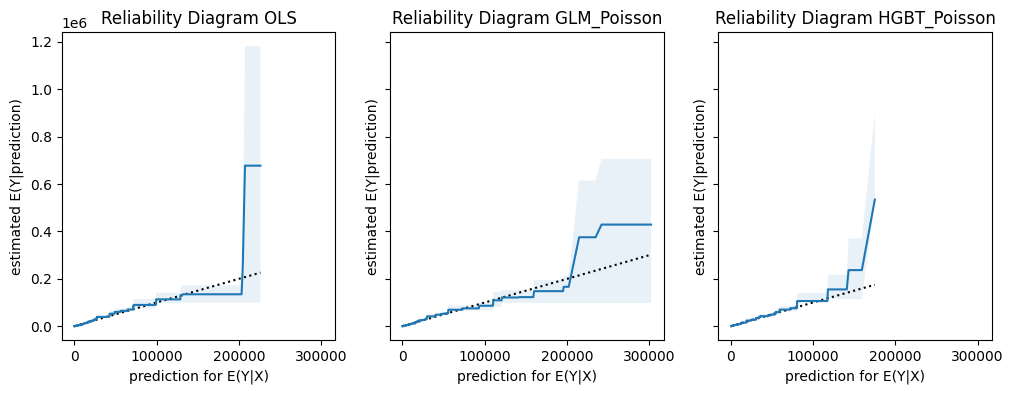

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)

plot_reliability_diagram(
    y_obs=y_test,
    y_pred=df_pred_test["OLS"],
    n_bootstrap=100,
    ax=axes[0],
)

plot_reliability_diagram(
    y_obs=y_test,
    y_pred=df_pred_test["GLM_Poisson"],
    n_bootstrap=100,
    ax=axes[1]
)

plot_reliability_diagram(
    y_obs=y_test,
    y_pred=df_pred_test["HGBT_Poisson"],
    n_bootstrap=100,
    ax=axes[2]
)
#fig.set_layout_engine(layout="tight")

For a better visual comparison, we use the `diagram_type="bias"` option to rotate the plots by 45 degrees (and mirror on the horizontal line) and plot all models in one go.
On top, we set the x-axis to a logarithmic scale and we zoom in a little.

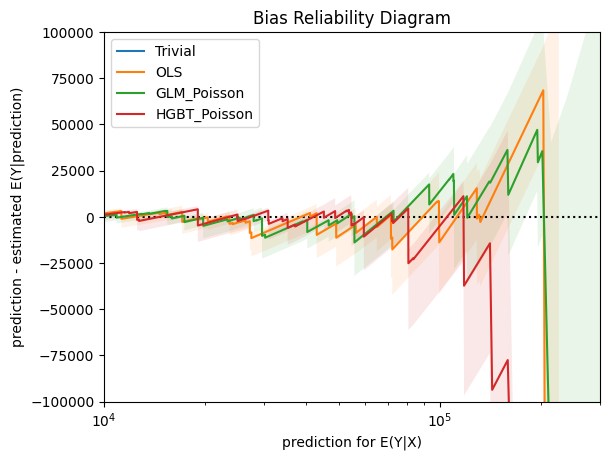

In [18]:
ax = plot_reliability_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
    n_bootstrap=100,
    diagram_type="bias",
)
ax.set_xlim(left=1e4, right=3e5)
ax.set_ylim(bottom=-1e5, top=1e5)
ax.set_xscale("log")

### 3.2 Conditional Bias

### Unconditional Bias

In [19]:
compute_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=None,
)

model,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,f64,u32,f64,f64,f64
"""Trivial""",-391.458696,20505,20505.0,394.427909,0.320979
"""OLS""",-158.226277,20505,20505.0,370.470343,0.669314
"""GLM_Poisson""",-142.672362,20505,20505.0,370.458593,0.70015
"""HGBT_Poisson""",-94.439905,20505,20505.0,370.823364,0.798976


#### Bias Conditional on Gender

In [20]:
compute_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=X_test["Gender"],
)

model,Gender,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,cat,f64,u32,f64,f64,f64
"""Trivial""","""F""",-4693.414762,4441,4441.0,925.511027,4.1151e-7
"""Trivial""","""M""",797.845767,16064,16064.0,433.155234,0.065502
"""OLS""","""F""",-1212.773117,4441,4441.0,878.188822,0.16735
"""OLS""","""M""",133.310235,16064,16064.0,405.795301,0.742526
"""GLM_Poisson""","""F""",-184.995122,4441,4441.0,878.931176,0.833305
"""GLM_Poisson""","""M""",-130.971952,16064,16064.0,405.685045,0.74682
"""HGBT_Poisson""","""F""",-303.384575,4441,4441.0,875.609671,0.728996
"""HGBT_Poisson""","""M""",-36.675756,16064,16064.0,406.774313,0.928159


<Axes: title={'center': 'Bias Plot'}, xlabel='Gender', ylabel='bias'>

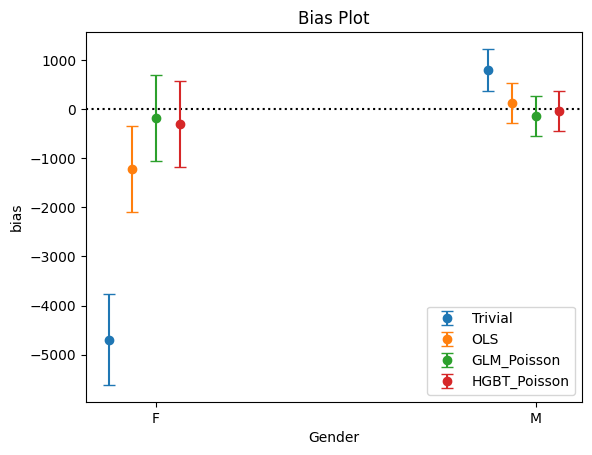

In [21]:
plot_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=X_test["Gender"],
)

#### Bias Conditional on LogWeeklyPay

<Axes: title={'center': 'Bias Plot'}, xlabel='binned LogWeeklyPay', ylabel='bias'>

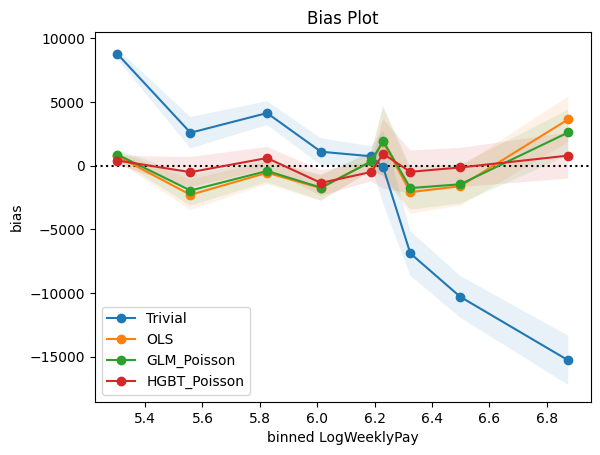

In [22]:
plot_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=X_test["LogWeeklyPay"],
)

#### Bias Conditional on Age
Age is given as an integer in the data. We can pass `n_bins` to appropriate number to see all integer ages that occur in the test data.

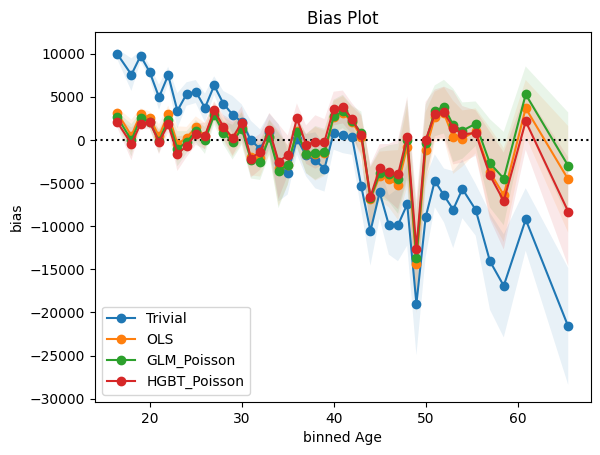

In [23]:
ax = plot_bias(
    y_obs=y_test,
    y_pred=df_pred_test,
    feature=X_test["Age"],
    n_bins=X_test["Age"].nunique(),
)

## 4. Predictive Model Performance
### 4.1 Score Decomposition of the Gamma Deviance
We use the [Gamma deviance](https://lorentzenchr.github.io/model-diagnostics/reference/model_diagnostics/scoring/scoring/#model_diagnostics.scoring.scoring.GammaDeviance) and evaluate on the test set.
On top, we additively decompose the scores in terms of miscalibration (smaller is better), discrimination (larger is better) and uncertainty (property of the data, same for all models).

In [24]:
import polars as pl
from model_diagnostics.scoring import GammaDeviance, decompose


gamma_deviance = GammaDeviance()

df_list = []
for model in ["Trivial", "OLS", "GLM_Poisson", "HGBT_Poisson"]:
    df = decompose(
        scoring_function=gamma_deviance,
        y_obs=y_test,
        y_pred=df_pred_test[model],
    )
    df = df.with_columns(pl.lit(model).alias("model"))
    df_list.append(df)
df = pl.concat(df_list).select(
    ["model", "miscalibration", "discrimination", "uncertainty", "score"]
)
df

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""Trivial""",0.000901,8.8818e-16,5.086002,5.086903
"""OLS""",0.271994,1.605604,5.086002,3.752392
"""GLM_Poisson""",0.470965,1.624191,5.086002,3.932776
"""HGBT_Poisson""",0.088114,1.696757,5.086002,3.477359


First, the HGBT model has the best (smallest) overall Gamma deviance in column **score**.
We also see that the uncertainty term is model independent as it is a property of the data and the scoring function only.
Very typical for insurance claims, it is the largest component which shows the insurance claims happen to a large part by chance.
The deciding difference of the scores then stems from the miscalibration term.
Except for the trivial model, the HGBT model has the best (smallest) one.
The discrimination term (larger is better) is quite similar among the non-trivial models.

### 4.2 Murphy Diagram
How does the ranking of the model performances change with other scoring functions?
Is one model dominating the others for a wide range of scoring functions?
Such questions can be handily answered by a Murphy diagram.
It plots the mean score for a wide range of elementary scoring functions, parametrized by `eta` on the x-axis.
We explicitly specify the `etas` to zoom into the range where differences can be spotted.

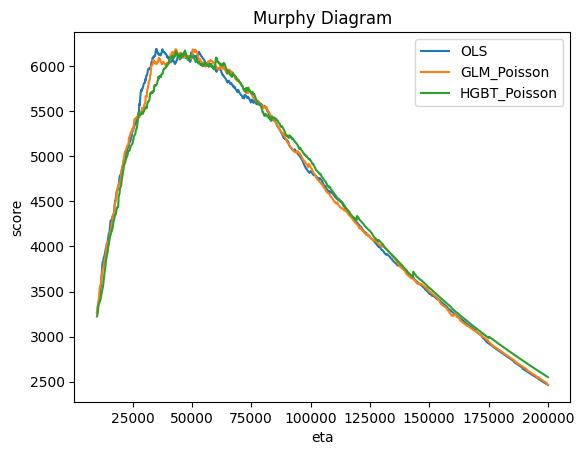

In [25]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram


ax = plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test.loc[:, ["OLS", "GLM_Poisson", "HGBT_Poisson"]],
    etas=np.linspace(1e4, 0.2e6, 1000),
)

We see that there is no clear winner.
Indeed, for other scoring functions like the squared error, the HGBT model is not the best performing one.

In [26]:
df_list = []
for model in ["Trivial", "OLS", "GLM_Poisson", "HGBT_Poisson"]:
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=df_pred_test[model],
    )
    df = df.with_columns(pl.lit(model).alias("model"))
    df_list.append(df)
pl.concat(df_list)[:, [-1, 0, 1, 2, 3]]

model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""Trivial""",153239.910611,0.0,3.1899e9,3.1900e9
"""OLS""",6.8568e7,4.4428e8,3.1899e9,2.8142e9
"""GLM_Poisson""",3.8145e7,4.1404e8,3.1899e9,2.8140e9
"""HGBT_Poisson""",2.7010e7,3.9737e8,3.1899e9,2.8195e9
